tgb - 11/29/2021 - Generates high-resolution figures (in EPS format) for the climate-invariant ML manuscript

*Replace the path below with the folder containing the figure data*

In [12]:
path_Fig = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/CIML_Fig_Data/'

# Import

In [112]:
import xarray as xr
import numpy as np
import math

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
from matplotlib.ticker import NullFormatter

import pickle

import warnings

# Fig2

## Load data

In [28]:
STaqua_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')
STaqua_0K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')
STaqua_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p4K.nc')

ST_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_m4K.nc')
ST_0K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p0K.nc')
ST_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p4K.nc')

In [14]:
hf = open(path_Fig+'SPCAM5_annual_mean_SST.pkl','rb')
ST_mean = pickle.load(hf)
hf.close()

In [15]:
hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_HH = pickle.load(hf)
hf.close()

In [17]:
hf = open(path_Fig+'Sample_SAM_Subgrid.pkl','rb')
inpoup_HH = pickle.load(hf)
hf.close()

In [32]:
with open(path_Fig+'SAM_SST') as f:
    TS_HH_lines = f.readlines()

TS_HH = []
for s in TS_HH_lines: 
    TS_HH.append(float(s))
    
TS_HH = np.array(TS_HH)

inpoup_HH['TS'] = {}
inpoup_HH['TS']['qobs'] = np.tile(np.expand_dims(TS_HH,axis=1),inpoup_HH['T_xy']['qobs'].shape[1])
inpoup_HH['TS']['qobs4K'] = inpoup_HH['TS']['qobs']+4

## Create colorbars

In [20]:
vmin0_SST = 270
vmax0_SST = 310

In [21]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_SST = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0_SST, vmax0_SST, 11)
norm_SST = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [22]:
vmin0_SGS = -15
vmax0_SGS = 15

In [23]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_SGS = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0_SGS, vmax0_SGS, 101)
norm_SGS = mpl.colors.BoundaryNorm(bounds, cmap.N)

## Plot all maps together

In [78]:
# CBAR_position = [0.07, 0.525, 0.01, 0.35]
# CBAR2_position = [0.07, 0.135, 0.01, 0.35]
CBAR_position = [0.87, 0.525, 0.01, 0.35]
CBAR2_position = [0.87, 0.135, 0.01, 0.35]
it = 13; # Time index to select subgrid heating
ip = 18; # Pressure index to select 500-hPa level
Y0 = 1.5; # Position of the text above the subplots
X1 = -0.125; # Position of (a) and (b)
Y1 = 1.25; # Position of (a) and (b)

In [79]:
fz = 12
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [80]:
Titles = ['SPCAM3','SPCAM5','SAM']

Not available
Not available


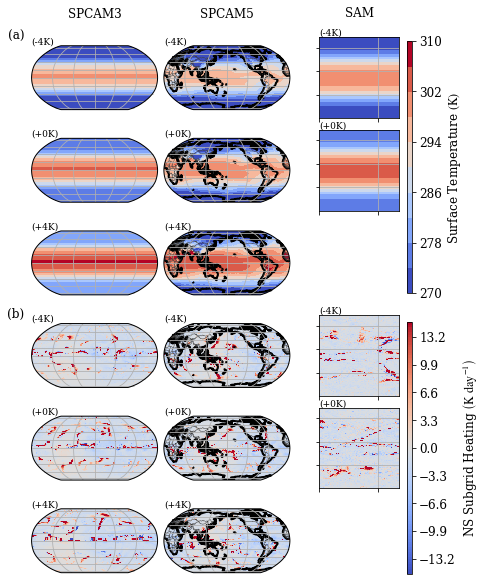

In [81]:
fig, ax = plt.subplots(6,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(7,10))

TEXT = {}
for isub in range(6): # Loop over 6 subplots
    
    icol = isub-3*math.floor(isub/3) # Determine location of subplot (out of 6)
    if math.floor(isub/3)==0: cmap0 = cmap_SST; norm0 = norm_SST; vmin0 = vmin0_SST; vmax0 = vmax0_SST;
    else: cmap0 = cmap_SGS; norm0 = norm_SGS; vmin0 = vmin0_SGS; vmax0 = vmax0_SGS;
    
    for iax in range(3): # In each subplot, loop over 3 climates (from top to bottom)
        
        if iax==0: 
            if isub%3==0: HH = False; data = STaqua_m4K;
            elif isub%3==1: data = ST_m4K;
            elif isub%3==2: HH = True; Avail=True; dataset = 'qobs';
            if isub==1: toplot = ST_mean['st_m4K'];
            tit = '(-4K)'
        elif iax==1: 
            if isub%3==0: HH = False; data = STaqua_0K;
            elif isub%3==1: data = ST_0K; 
            elif isub%3==2: HH = True; Avail=True; dataset = 'qobs4K';
            if isub==1: toplot = ST_mean['st_0K'];
            tit = '(+0K)'
        elif iax==2: 
            if isub%3==0: HH = False; data = STaqua_p4K;
            elif isub%3==1: data = ST_p4K; 
            elif isub%3==2: HH=True; Avail=False;
            if isub==1: toplot = ST_mean['st_p4K'];
            tit = '(+4K)'
        
        if isub==0: toplot = data.TS.mean(dim='time')
        elif isub==2: toplot = 'TS'
        elif isub==3: toplot = 24*3600*data.TPHYSTND[it,ip,:,:]
        elif isub==4: toplot = 24*3600*data.PTTEND[it,ip,:,:]
        elif isub==5: toplot = 'Tout_482'

        irow = iax+3*math.floor(isub/3) # To make 6 panels
        
        if HH:
            ax[irow][icol].remove()
            
            if Avail:
                ax[irow][icol] = fig.add_subplot(6,3,3*irow+icol+1)
                imag = ax[irow][icol].pcolormesh(coor_HH['x'],coor_HH['y'],
                                                 inpoup_HH[toplot][dataset],
                                                 cmap=cmap0,norm=norm0,
                                                 vmin=vmin0,vmax=vmax0)
#                 imag = ax[irow][icol].matshow(inpoup_HH[toplot][dataset],
#                                               cmap=cmap0,norm=norm0,
#                                               vmin=vmin0,vmax=vmax0)
                ax[irow][icol].set_aspect(0.4) # equal aspect ratio makes it hard to read
# so this is a compromise to avoid overly stretching the channel in the x-direction
                ax[irow][icol].grid()
                ax[irow][icol].xaxis.set_ticklabels([])
                ax[irow][icol].yaxis.set_ticklabels([])
                ax[irow][icol].set_title(tit,loc='left',pad=-0.1,fontsize=3*fz/4)
            else:
                tit = ''
                print('Not available')

        else:
            imag = ax[irow][icol].pcolormesh(data.lon, data.lat, 
                                             toplot,cmap=cmap0, norm=norm0,
                                             transform=ccrs.PlateCarree(),
                                             vmin=vmin0,vmax=vmax0)
            ax[irow][icol].gridlines()
            ax[irow][icol].set_title(tit,loc='left',pad=-0.1,fontsize=3*fz/4)
        if icol%3==1:
                ax[irow][icol].coastlines(linewidth=2.0,edgecolor='0.25')
                ax[irow][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        # Colorbar
        if isub==0 and iax==0:
            cbar_ax = fig.add_axes(CBAR_position)
            CBAR = fig.colorbar(imag, label="Surface Temperature "+r'$\left(\mathrm{K}\right)$', 
                                cax=cbar_ax)
            cbar_ax.yaxis.set_ticks_position('right')
            cbar_ax.yaxis.set_label_position('right')
        elif isub==3 and iax==0:
            cbar2_ax = fig.add_axes(CBAR2_position)
            fig.colorbar(imag, label="NS Subgrid Heating "+r'$\left(\mathrm{K\ day^{-1}}\right)$', 
                         cax=cbar2_ax)
            cbar2_ax.yaxis.set_ticks_position('right')
            cbar2_ax.yaxis.set_label_position('right')
        
        # Title of each column
        plt.draw()
        if iax==0:

            if isub<3:
                TEXT[isub]= ax[0][isub].text(0.5,Y0,Titles[isub],fontsize=fz,
                             va='center',ha ='center',transform = ax[0][isub].transAxes)
        # (a) and (b) subplots
        if isub==0:
            if iax==0: ax[0][isub].text(X1,Y1,'(a)',fontsize=fz,va='top',ha='center',
                                       transform = ax[0][isub].transAxes)
        elif isub==3: 
            if iax==0: ax[irow][icol].text(X1,Y1,'(b)',fontsize=fz,va='top',ha='center',
                                       transform = ax[irow][icol].transAxes)

plt.subplots_adjust(wspace=0.05, hspace=0.15)
TEXT[2].set_position((0.5,1.3))
plt.savefig(path_Fig+'Fig2.pdf', format='pdf')

# Fig 4

## Load data

Load

In [83]:
hf = open(path_Fig+'SPCAM_Q_histogram.pkl','rb')
Q_data = pickle.load(hf)
hf.close()

In [84]:
hf = open(path_Fig+'SPCAM_T850_histogram.pkl','rb')
T850_data = pickle.load(hf)
hf.close()

In [85]:
hf = open(path_Fig+'SPCAM_T150_histogram.pkl','rb')
T150_data = pickle.load(hf)
hf.close()

In [86]:
hf = open(path_Fig+'SPCAM_B_histogram.pkl','rb')
B_data = pickle.load(hf)
hf.close()

In [87]:
hf = open(path_Fig+'SPCAM_LHF_histogram.pkl','rb')
LHF_data = pickle.load(hf)
hf.close()

In [89]:
hf = open(path_Fig+'SAM_Q_histogram.pkl','rb')
Q_data_HH = pickle.load(hf)
hf.close()

HHdic = {}
HHdic['QV'] = 'qv';
HHdic['RH'] = 'RH';
HHdic['QfromQsat'] = 'q_deficit'

In [90]:
hf = open(path_Fig+'SAM_T850_histogram.pkl','rb')
T850_data_HH = pickle.load(hf)
hf.close()

hf = open(path_Fig+'SAM_T150_histogram.pkl','rb')
T150_data_HH = pickle.load(hf)
hf.close()

HHdic['T'] = 'Tin'
HHdic['BMSE'] = 'BMSE'
HHdic['TfromNS'] = 'T_mTNS'

Group in structure

In [91]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
]

In [92]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [93]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [94]:
hisT150 = {}
edgT150 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = {}
        edgT150[key][path] = {}

In [95]:
hisT200 = {}
edgT200 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = {}
        edgT200[key][path] = {}

In [96]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [97]:
hisQ = Q_data['hisQ']
edgQ = Q_data['edgQ']
# Convert specific humidities to g/kg
for ipath,path0 in enumerate(path_array):
    for ikey,key in enumerate(['QV','QfromQsat']):
        edgQ[key][path0] *= 1e3

In [99]:
hisT = T850_data['hisT']
edgT = T850_data['edgT']
# Load buoyancy from MSE
ilevB = 23
for ikey,key in enumerate(['BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = B_data['hisT'][ilevB][path]
        edgT[key][path] = B_data['edgT'][ilevB][path]
        
hisT150 = T150_data['hisT']
edgT150 = T150_data['edgT']
# Load buoyancy from MSE
ilevB = 10
for ikey,key in enumerate(['BMSE']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = B_data['hisT'][ilevB][path]
        edgT150[key][path] = B_data['edgT'][ilevB][path]

# Redefine Tarray to replace BCONS with BMSE for now
Tarray = ['T','BMSE','TfromNS']

hisLHF = LHF_data['hisLHF']
edgLHF = LHF_data['edgLHF']

Set histograms to zero for the (-4K) SAM simulations and load Janni values for the other sims

In [100]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    '1','2','3' # dummy paths for HH simulations
]

In [102]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [103]:
path_SAM = ['1','2','3']
for ipath,path0 in enumerate(path_SAM):
    
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if ipath==2: 
            edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            hisQ[key][path0] = 0*edg2bin(edgQ[key][path0])**0
        elif ipath==0: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs'] # Conversion in g/kg
        elif ipath==1: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs4K']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs4K']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs4K'] # Conversion in g/kg
    
    for ikey,key in enumerate(['T','BMSE','TfromNS']):
        if ipath==2: 
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT[key][path0] = 0*edg2bin(edgT[key][path0])**0
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = 0*edg2bin(edgT150[key][path0])**0
        elif ipath==0: 
            hisT[key][path0] = T850_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
        elif ipath==1: 
            hisT[key][path0] = T850_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs4K']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs4K']
            
    for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
            edgLHF[key][path0] = np.linspace(0,100,101)
            hisLHF[key][path0] = 0*edg2bin(edgLHF[key][path0])**0

## Plot all PDFs together

In [157]:
YLAB = {}

YLAB[0] = {}
YLAB[0]['QV'] = '$q\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'
YLAB[0]['RH'] = '$\\mathrm{RH}\\ \\left[1\\right]$'
YLAB[0]['QfromQsat'] = '$q_{\\mathrm{deficit}}\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'

YLAB[1] = {}
YLAB[1]['T'] = '$T\\ \\left[\\mathrm{K}\\right]$'
YLAB[1]['BMSE'] = '$B_{\\mathrm{plume}}\\ \\left[\\mathrm{m\\ s^{-2}}\\right]$'
YLAB[1]['TfromNS'] = '$T_{\\mathrm{from\\ NS}}\\ \\left[\\mathrm{K}\\right]$'

YLAB[2] = {}
# YLAB[2]['LHF'] = '$\\mathrm{LHF}\\ \\left[\\mathrm{W\\ m^{-2}}\\right]$'
# YLAB[2]['LHF_nsQ'] = '$\\mathrm{LHF}_{q}\\ \\left[\\mathrm{kg\\ m^{-2}s^{-1}}\\right]$'
# YLAB[2]['LHF_nsDELQ'] = '$\\mathrm{LHF}_{\\Delta q}\\ \\left[\\mathrm{kg\\ m^{-2}\\ s^{-1}}\\right]$'
YLAB[2]['LHF'] = '$\\mathrm{LHF}$'
YLAB[2]['LHF_nsQ'] = '$\\mathrm{LHF}_{q}$'
YLAB[2]['LHF_nsDELQ'] = '$\\mathrm{LHF}_{\\Delta q}$'

In [149]:
Y0 = [1.2,0.95,1]
delY = 5e-3
TITLE = ["Aquaplanet (SPCAM3)","Earth-like (SPCAM5)","Hypohydrostatic (SAM)"]
PANEL = ['(a)','(b)','(c)']

In [150]:
path_aqua = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
]
path_RG = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]
color_array = ['b','gray','red']

In [151]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

plot_log = [True,True,True]

ivar= 0 VARarray= ['QV', 'QfromQsat', 'RH']
ivar= 1 VARarray= ['T', 'TfromNS', 'BMSE']
ivar= 2 VARarray= ['LHF', 'LHF_nsQ', 'LHF_nsDELQ']


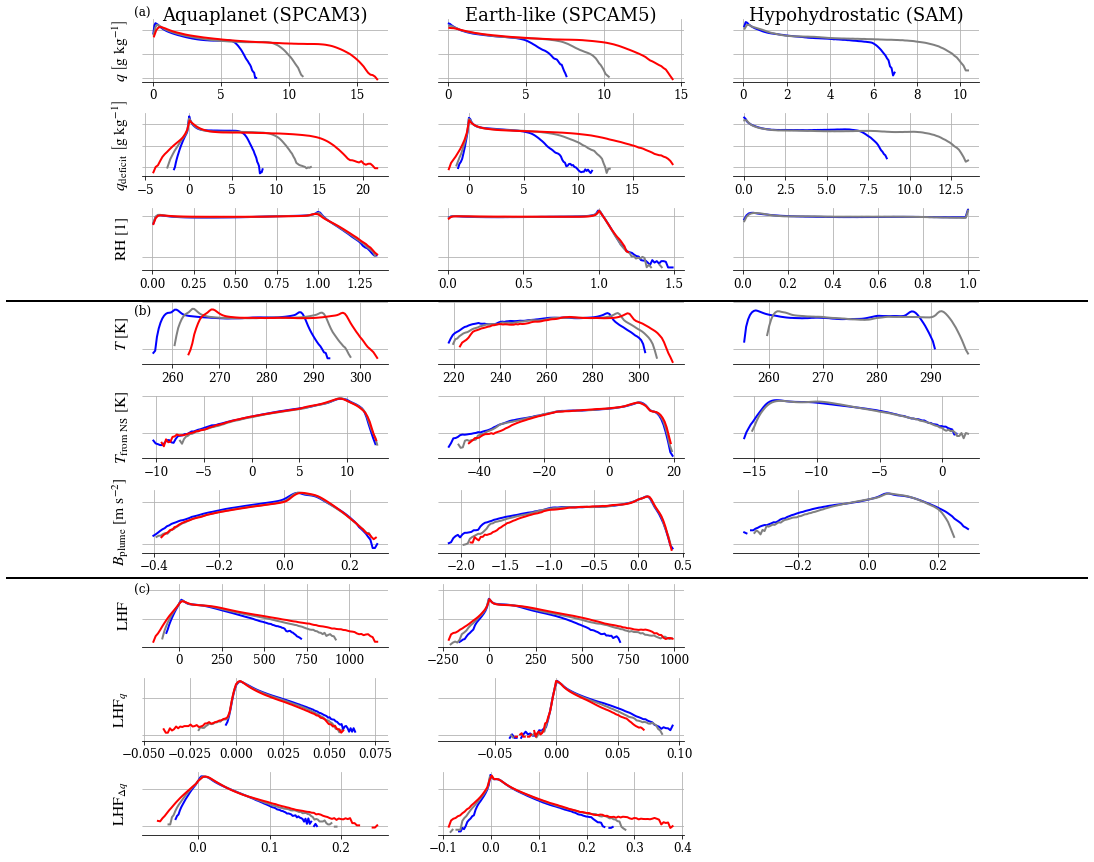

In [158]:
fig,ax = plt.subplots(9,3,figsize=(15,15))

warnings.filterwarnings("ignore") # We are taking the log of zero to facilitate visualization of certain PDFs

for ivar in range(3):
    if ivar==0: VARarray = ['QV','QfromQsat','RH']; edg = edgQ; his = hisQ;
    elif ivar==1: VARarray = ['T','TfromNS','BMSE']; edg = edgT; his = hisT;
    elif ivar==2: VARarray = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
    print('ivar=',ivar,'VARarray=',VARarray)
        
    for iconfig in range(3):
        if iconfig==0: path0 = path_aqua
        elif iconfig==1: path0 = path_RG
        elif iconfig==2: path0 = path_SAM

        for ipath,path in enumerate(path0):
            for iresc,resc in enumerate(VARarray):
                
                if iconfig==2 and ivar==2:
                    if ipath==0:
                        fig.delaxes(ax[3*ivar+iresc,iconfig]);
                else:
                    if plot_log[ivar]: toplot = np.log10(his[resc][path])
                    else: toplot = his[resc][path]

                    ax[3*ivar+iresc,iconfig].plot(edg2bin(edg[resc][path]),
                                                  toplot,
                                                  color=color_array[ipath])
    
        # Additionally plot 150hPa temperature rescalings for temperature plots
#         if ivar==1:
#             for ipath,path in enumerate(path0):
#                 for iresc,resc in enumerate(VARarray):

#                     if plot_log[ivar]: toplot = np.log10(hisT150[resc][path])
#                     else: toplot = hisT150[resc][path]

#                     ax[3*ivar+iresc,iconfig].plot(edg2bin(edgT150[resc][path]),
#                                                   toplot,
#                                                   color=color_array[ipath],
#                                                   linestyle='--')        

    plt.draw()

    for iresc,resc in enumerate(VARarray):
        YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
        for iconfig in range(3):
            YLIM = ax[3*ivar+iresc,iconfig].get_ylim()
            YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
            YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
        for iconfig in range(3):
            ax[3*ivar+iresc,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
            ax[3*ivar+iresc,iconfig].grid()
            ax[3*ivar+iresc,iconfig].yaxis.set_major_formatter(NullFormatter())
            ax[3*ivar+iresc,iconfig].tick_params(axis='y', colors='white')
            for ipos,pos in enumerate(['top','right','left']):
                ax[3*ivar+iresc,iconfig].spines[pos].set_visible(False)
            
            if iconfig==0: ax[3*ivar+iresc,iconfig].set_ylabel(YLAB[ivar][resc],fontsize=1.3*fz)
                
plt.subplots_adjust(hspace=0.5)
#fig.tight_layout()
# Title of each column and letters of each panel
for iconfig in range(3):
    ax[0][iconfig].text(0.5,Y0[0],TITLE[iconfig],va='top',ha = 'center',
                        transform = ax[0][iconfig].transAxes,fontsize=1.5*fz)

for ivar in range(3):
    ax[3*ivar][0].text(0,Y0[ivar],PANEL[ivar],va='top',ha = 'center',
                       transform = ax[3*ivar][0].transAxes,fontsize=fz)

# Draw separators between three variables
# Adapted from [https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots]
# rearange the axes for no overlap

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, ax.flat)), mtrans.Bbox).reshape(ax.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(ax.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(ax.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys[[2,5]]:
    line = plt.Line2D([0,1],[y-delY,y-delY], transform=fig.transFigure, color="black")
    fig.add_artist(line)

plt.savefig(path_Fig+'Fig4.pdf', format='pdf')

# Fig 5

## Load data

In [159]:
hf = open(path_Fig+'SPCAM3_MSE_Progressive_Rescaling.pkl','rb')
MSEp = pickle.load(hf)
hf.close()

In [163]:
MSE_gen = MSEp['MSE_gen']

In [167]:
coor = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')

## Plot MSE profiles

In [168]:
path_array = [
    '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
    '2021_06_21_NN_RH_BMSE.hdf5',
    '2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_NN.hdf5',
]
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
LAB2 = ['','','','','BF (+4K)','','','']
XLAB = ['$\\dot{q}$','$\\dot{T}$','$\\dot{q}$','$\\dot{q}$ (Zoom)',
        '$\\dot{T}$','$\\dot{T}$ (Zoom)','lw','sw','lw','lw (Zoom)',
        'sw','sw (Zoom)']
YLAB = 'Pressure [hPa]'

fz = 15
lw = 2
siz = 50
TITa = '(a) MSE in Cold Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
TITb = '(b) '+r'$\bf{Generalization}$'+' Test: MSE in Warm Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
Y0 = 1.1

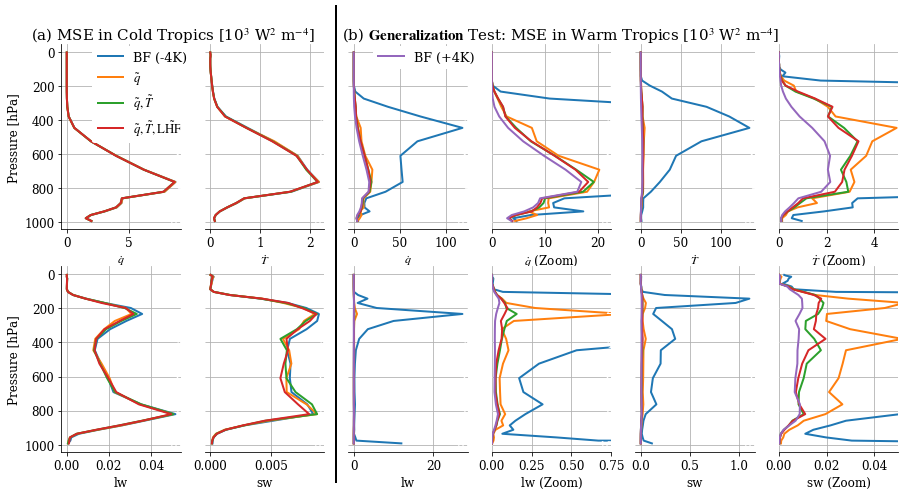

In [177]:
fig, ax = plt.subplots(2,6,figsize=(15,7.5))

for isub in range(12):
    ilin = int(np.floor(isub/6))
    icol = isub-6*ilin
    if icol<2: ilim=4;
    else: ilim=5; # Do not depict reference BF (+4K) in cold climates
    for ipath,path in enumerate(path_array[:ilim]):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][:30,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][30:60,:],axis=1)/1e3
        elif isub==2 or isub==3: toplot = np.mean(MSE_gen['AQ+4K'][path][:30,:],axis=1)/1e3
        elif isub==4 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][30:60,:],axis=1)/1e3
        elif isub==6: toplot = np.mean(MSE_gen['AQ-4K'][path][60:90,:],axis=1)/1e3
        elif isub==7: toplot = np.mean(MSE_gen['AQ-4K'][path][90:120,:],axis=1)/1e3
        elif isub==8 or isub==9: toplot = np.mean(MSE_gen['AQ+4K'][path][60:90,:],axis=1)/1e3
        elif isub==10 or isub==11: toplot = np.mean(MSE_gen['AQ+4K'][path][90:120,:],axis=1)/1e3
        
        if isub==0: ax[ilin,icol].plot(toplot,coor.lev,label=LAB[ipath])
        elif isub==2: ax[ilin,icol].plot(toplot,coor.lev,label=LAB2[ipath])
        else: ax[ilin,icol].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0,0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    elif isub==2:
        leg = ax[0,2].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[ilin,icol].invert_yaxis(); ax[ilin,icol].grid()
    ax[ilin,icol].set_xlabel(XLAB[isub])
    if isub==0 or isub==6: ax[ilin,icol].set_ylabel(YLAB)
    else: 
        ax[ilin,icol].spines['left'].set_visible(False)
        ax[ilin,icol].tick_params(axis='y', colors='white')

    for ipos,pos in enumerate(['right','top']):
        ax[ilin,icol].spines[pos].set_visible(False)

    if isub==3: ax[ilin,icol].set_xlim((0,22.5))
    elif isub==5: ax[ilin,icol].set_xlim((0,5))
    elif isub==9: ax[ilin,icol].set_xlim((0,0.75))
    elif isub==11: ax[ilin,icol].set_xlim((0,0.05))

plt.draw()
ax[0,0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);
ax[0,2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);

xs = 0.5*(ax[0,1].get_position().x1+ax[0,2].get_position().x0)
line = plt.Line2D([xs,xs],[0.07,0.95], transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.savefig(path_Fig+'Fig5.pdf', format='pdf')

# Fig 6

## Load data

In [185]:
hf = open(path_Fig+'SPCAM_R2_dT500.pkl','rb')
R2_SPCAM = pickle.load(hf)
hf.close()
R2_SPCAM = R2_SPCAM['R2_SH_geo']

In [186]:
hf = open(path_Fig+'SAM_R2_dT500.pkl','rb')
R2_Janni = pickle.load(hf)
hf.close()

In [187]:
hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_Janni = pickle.load(hf)
hf.close()

## Make figure

In [188]:
vmin0 = -1
vmax0 = 1

Possibility of Combining two colormaps using [https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps]

In [182]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [183]:
CBAR_position = [0.95, 0.25, 0.015, 0.5]
Y0 = 1.5; # Position of the text above the subplots

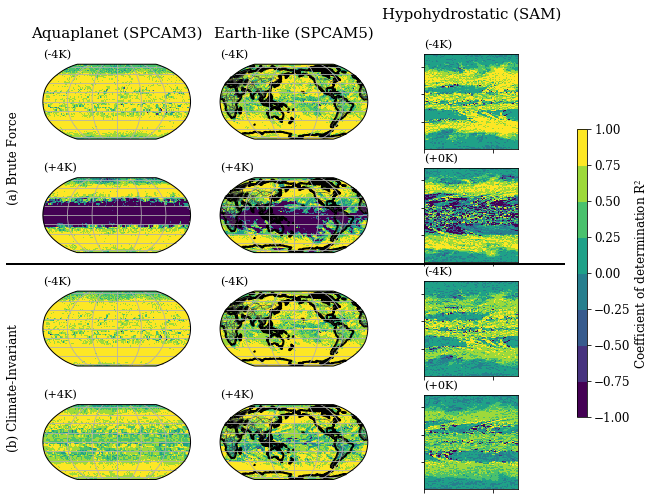

In [184]:
fig, ax = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(9,8))

for isub in range(12):
    ilin = int(np.floor(isub/3))
    icol = isub-3*ilin
    
    if ilin%2==0: 
        tit = '(-4K)'; 
        if icol==0: dataset = 'AQ-4K'; data = STaqua_m4K
        elif icol==1: dataset = 'RG-4K'; data = ST_m4K
    else: 
        tit = '(+4K)'
        if icol==0: dataset = 'AQ+4K'; data = STaqua_p4K
        elif icol==1: dataset = 'RG+4K'; data = ST_p4K
        
    if isub==0 or isub==3: toplot = R2_SPCAM[dataset]['2021_04_26_NN.hdf5']
    elif isub==1 or isub==4: toplot = R2_SPCAM[dataset]['2021_06_03_RG2AQ_NN.hdf5']
    elif isub==6 or isub==9: toplot = R2_SPCAM[dataset]['2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5']
    elif isub==7 or isub==10: toplot =  R2_SPCAM[dataset]['2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5']
    else: toplot = -toplot**0
    #print('isub = ',isub,'and mean R2 is ',np.mean(toplot.flatten()))
    imag = ax[ilin][icol].pcolormesh(data.lon, data.lat, 
                                     toplot,cmap=cmap_R2, norm=norm_R2,
                                     transform=ccrs.PlateCarree(),
                                     vmin=-1,vmax=1)
    ax[ilin][icol].gridlines()
    
    if icol%3==2: 
        ax[ilin][icol].remove()
        ax[ilin][icol] = fig.add_subplot(4,3,3*ilin+icol+1)
        if isub==2: toplot = R2_Janni['No_Climate_invar']['qobs']['Tout_lev15']; tit = '(-4K)'
        elif isub==5: toplot = R2_Janni['No_Climate_invar']['qobs4K']['Tout_lev15']; tit = '(+0K)'
        elif isub==8: toplot = R2_Janni['Climate_invar']['qobs']['Tout_lev15']; tit = '(-4K)'
        elif isub==11: toplot = R2_Janni['Climate_invar']['qobs4K']['Tout_lev15']; tit = '(+0K)'
        imag = ax[ilin][icol].pcolormesh(coor_Janni['x'],coor_Janni['y'],toplot.T,
                                                 cmap=cmap_R2,norm=norm_R2,
                                                 vmin=-1,vmax=1)
        ax[ilin][icol].set_aspect(0.4)
        ax[ilin][icol].xaxis.set_ticklabels([])
        ax[ilin][icol].yaxis.set_ticklabels([])
    
    
    ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4)
    if icol==1:
            ax[ilin][icol].coastlines(linewidth=2.0,edgecolor='0.25')
            ax[ilin][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

    # Colorbar
    if isub==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

    # Title of each column
    if ilin==0:
        if isub==0: ax[0][isub].text(0.5,Y0,"Aquaplanet (SPCAM3)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
        elif isub==1: ax[0][isub].text(0.5,Y0,"Earth-like (SPCAM5)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
        elif isub==2: ax[0][isub].text(0.5,Y0,"Hypohydrostatic (SAM)",fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
            
plt.draw()
# Horizontal line in the middle
ys = 0.7*ax[1,0].get_position().y0+0.3*ax[2,0].get_position().y1
line = plt.Line2D([0.07,0.93],[ys,ys], transform=fig.transFigure, color="black")
fig.add_artist(line)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

# Fig 7